In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import pickle
import warnings
from pathlib import Path
import jax.numpy as jnp
import pandas as pd

# GPUDrive dependencies
working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)
from pygpudrive.env.config import EnvConfig, RenderConfig, SceneConfig, SelectionDiscipline
from pygpudrive.env.env_torch import GPUDriveTorchEnv


sns.set("notebook", font_scale=1.05, rc={"figure.figsize": (7, 2)})
sns.set_style("ticks", rc={"figure.facecolor": "none", "axes.facecolor": "none"})
%config InlineBackend.figure_format = 'png'
plt.rcParams['figure.dpi'] = 120
warnings.filterwarnings("ignore")

### Configurations

In [3]:
BASE_DIR = "/home/emerge/daphne/gpudrive"
SCENARIO_ID = "ab2a72c63f8fd589"

### Load debug scenario and saved samples 

- Unprocessed waymax scenario object 
- Processed VBD inputs (waymax)
- Processed VBD inputs (gpudrive)

In [4]:
with open(f'{BASE_DIR}/data/processed/waymax/scenario_{SCENARIO_ID}.pkl', 'rb') as f:
    scenario = pickle.load(f);
    
with open(f"{BASE_DIR}/waymax_vbd_sample_ab2a72c63f8fd589.pkl", "rb") as f:
    waymax_vbd_data = pickle.load(f)

with open(f"{BASE_DIR}/gpudrive_vbd_sample_ab2a72c63f8fd589.pkl", "rb") as f:
    gpudrive_vbd_data = pickle.load(f)

2024-10-15 11:13:30.574883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-15 11:13:30.581888: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-15 11:13:30.583986: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-15 11:13:31.148063: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Initialize simulator

In [5]:
env_config = EnvConfig(
    init_steps=10, # Warmup period
    enable_vbd=True, # Use VBD
    dynamics_model="state", # Use state-based dynamics model
    dist_to_goal_threshold=1e-5, # Trick to make sure the agents don't disappear when they reach the goal
    collision_behavior="ignore", # Ignore collisions
)

# Make env
gpudrive_env = GPUDriveTorchEnv(
    config=env_config,
    scene_config=SceneConfig(path=f"{BASE_DIR}/data/debug", num_scenes=1),
    render_config=RenderConfig(draw_obj_idx=True, render_init=True, resolution=(650, 650)),
    max_cont_agents=32, # Maximum number of agents to control per scene
    device="cpu",
)


--- Ratio unique scenes / number of worls =         1 / 1 ---



### 1. **Polylines** 

- Observation: VBD trajectories in gpudrive driving through road edges. Why?
- polyline feature: x, y, heading, traffic_light, type

#### Inspect **unprocessed waymax roadpoints**

In [6]:
scenario.roadgraph_points.shape  # max roadpoints

(20000,)

In [7]:
scenario.roadgraph_points.xyz.shape 

(20000, 3)

In [8]:
scenario.roadgraph_points.dir_xy.shape # yaw_xy

(20000, 2)

In [9]:
scenario.roadgraph_points.types.shape # road types

(20000,)

- Meaning of [TL states](https://github.com/waymo-research/waymax/blob/720f9214a9bf79b3da7926497f0cd0468ca3e630/waymax/datatypes/traffic_lights.py#L26)

In [10]:
jnp.unique(scenario.log_traffic_light.state) # -1 means ??

Array([-1], dtype=int32)

In [11]:
scenario.roadgraph_points.types.shape

(20000,)

In [20]:
scenario.roadgraph_points.shape

(20000,)

In [12]:
df_polylines_waymax = pd.DataFrame({
    'x': scenario.roadgraph_points.x,
    'y': scenario.roadgraph_points.y,
    'yaw_x': scenario.roadgraph_points.dir_x,
    'yaw_y': scenario.roadgraph_points.dir_y,
    'type': scenario.roadgraph_points.types,
    #'tl_state': scenario.log_traffic_light.state[:, 0],
    'simulator': 'waymax'
})

df_polylines_waymax.head()

,x,y,yaw_x,yaw_y,type,simulator
0,4259.661621,11798.491211,0.999987,0.004590,15,waymax
1,4260.161133,11798.493164,0.999988,0.004493,15,waymax
2,4260.660645,11798.495117,0.999988,0.004396,15,waymax
3,4261.159668,11798.498047,0.999989,0.004300,15,waymax
4,4261.659180,11798.500000,0.999989,0.004203,15,waymax


In [13]:
# Note: In contrast to Waymax, these have already been filtered for proximity to vehicles
gpudrive_global_roadgraph = gpudrive_env.sim.agent_roadmap_tensor().to_torch().squeeze(0)

gpudrive_global_roadgraph.shape # agents, k_top_roadpoints, features

torch.Size([32, 256, 7])

In [14]:
df_polylines_gpudrive = pd.DataFrame({
    'x': gpudrive_global_roadgraph[:, :, 0].flatten(),
    'y': gpudrive_global_roadgraph[:, :, 1].flatten(),
    'yaw_x': gpudrive_global_roadgraph[:, :, 3].flatten(),
    'yaw_y': gpudrive_global_roadgraph[:, :, 4].flatten(), # Note: Placeholder, GPUDrive doesn't have a "yaw_y"
    'type': gpudrive_global_roadgraph[:, :, 6].flatten(),
    'simulator': 'gpudrive'
})

In [15]:
# sns.histplot(df_polylines_gpudrive['type'], discrete=True, alpha=0.5, label='GPUDrive')
# sns.histplot(df_waymax_vbd['type'], discrete=True, alpha=0.5, label='VDB', )
# plt.legend()
# plt.xticks(range(20));

# No #15 or #16 in GPUDrive -> why vehicles are colliding with the road

In [16]:
waymax_vbd_data.keys()

dict_keys(['agents_history', 'agents_interested', 'agents_type', 'agents_future', 'traffic_light_points', 'polylines', 'polylines_valid', 'relations', 'agents_id', 'anchors'])

In [17]:
waymax_vbd_data['polylines'].shape

(256, 30, 5)

In [18]:
waymax_vbd_data['polylines'][]

SyntaxError: invalid syntax (2887505685.py, line 1)

In [19]:
waymax_vbd_data['polylines'].shape

(256, 30, 5)

In [58]:
df_waymax_vbd = pd.DataFrame({
    'x': waymax_vbd_data['polylines'][:, :, 0].flatten(),
    'y': waymax_vbd_data['polylines'][:, :, 1].flatten(),   
    'yaw_x': waymax_vbd_data['polylines'][:, :, 2].flatten(),
    'yaw_y': waymax_vbd_data['polylines'][:, :, 3].flatten(),
    'type': waymax_vbd_data['polylines'][:, :, 4].flatten(),    
    'simulator': 'waymax_vbd'
})

In [42]:
df = pd.concat([df_polylines_gpudrive, df_polylines_waymax, df_waymax_vbd])

In [43]:
#df.groupby('simulator').describe().T

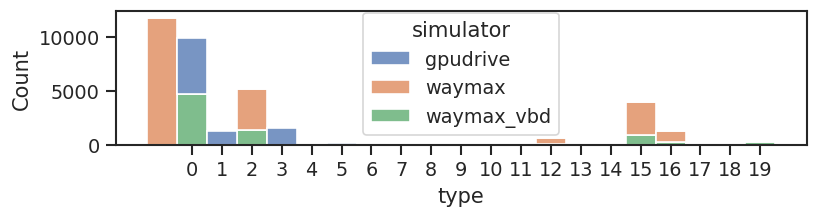

In [48]:
sns.histplot(df, x='type', hue='simulator', multiple='stack', bins=21, discrete=True,);
plt.tight_layout()
plt.xticks(range(20));

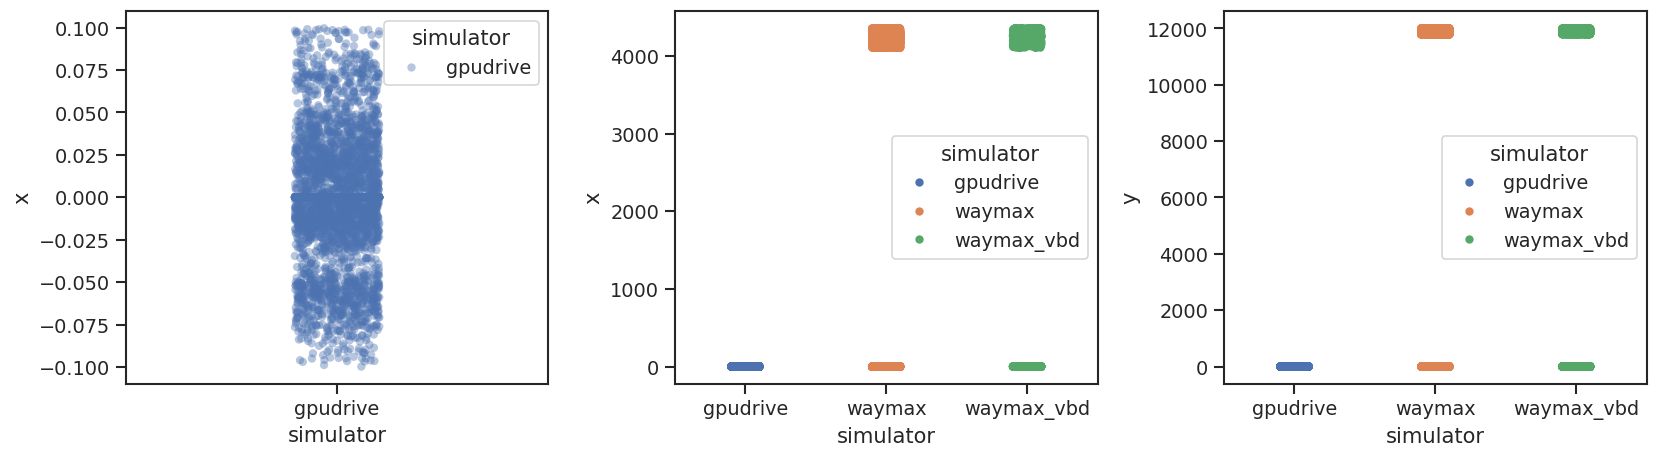

In [49]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

sns.stripplot(df_polylines_gpudrive, x='simulator', y='x', hue='simulator', ax=axs[0], alpha=0.4, legend=True)

sns.stripplot(df, x='simulator', y='x', hue='simulator', ax=axs[1], legend=True)

sns.stripplot(df, x='simulator', y='y', hue='simulator', ax=axs[2], legend=True)

plt.tight_layout()

AttributeError: 'RoadgraphPoints' object has no attribute 'dir'

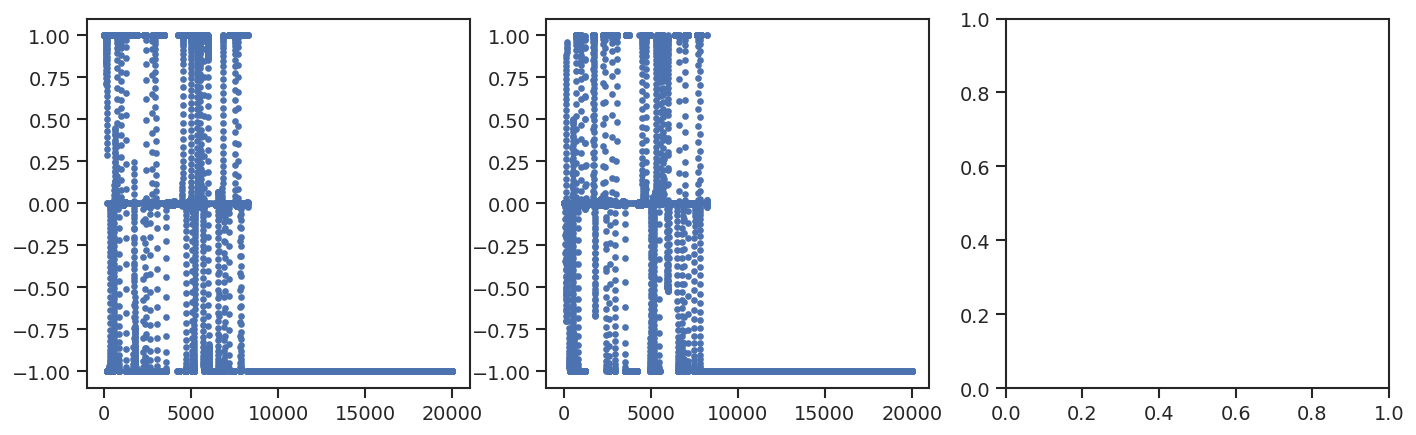

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

axs[0].plot(scenario.roadgraph_points.dir_x, '.', label='x')
axs[1].plot(scenario.roadgraph_points.dir_y, '.', label='y')
axs[2].plot(scenario.roadgraph_points.dir, '.', label='z')

plt.tight_layout()